In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle 
import torch
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import json
import re

In [4]:
import argparse
import os
import sys
sys.path.append('/u/dbeaglehole/mech_interp/neural_controllers/')

NEURAL_CONTROLLERS_DIR = '/u/dbeaglehole/mech_interp/neural_controllers'
from neural_controllers import NeuralController
from utils import load_model

### Llama-3.1-8b-it

In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['pca', 'linear', 'logistic', 'rfm']
model_name = 'llama_3_8b_it' #'llama_3.3_70b_4bit_it'
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []

# Initialize dictionaries to store selected test metrics based on best val layer
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Paths for validation and test metrics
    path_val = f'{NEURAL_CONTROLLERS_DIR}/results/agentharm_results/{model_name}_{method}_val_metrics.pkl'
    path_test = f'{NEURAL_CONTROLLERS_DIR}/results/agentharm_results/{model_name}_{method}_test_metrics.pkl'
    
    print(path_val, path_test)
    # Check if files exist
    if not os.path.exists(path_val):
        print(f"Validation file not found: {path_val}")
        continue
    if not os.path.exists(path_test):
        print(f"Test file not found: {path_test}")
        continue
        
    # Load validation and test results
    with open(path_val, 'rb') as f:
        val_results = pickle.load(f)
    with open(path_test, 'rb') as f:
        test_results = pickle.load(f)
    
    # Get layer keys (excluding any non-layer keys)
    layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
    layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
    
    # Store trivial metrics if they exist
    if 'trivial_metrics' in val_results:
        trivial_metrics_val.append(val_results['trivial_metrics'])
    if 'trivial_metrics' in test_results:
        trivial_metrics_test.append(test_results['trivial_metrics'])
    
    # Collect per-layer metrics for validation
    for key in layers_val:
        if key not in d_val[method]:
            d_val[method][key] = []
        d_val[method][key].append(val_results[key])
    
    # Collect per-layer metrics for test
    for key in layers_test:
        if key not in d_test[method]:
            d_test[method][key] = []
        d_test[method][key].append(test_results[key])
    
    # Identify the layer with the highest validation accuracy
    best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
    best_test_metrics = test_results.get(best_layer, {})
    
    # Store all metrics for the selected test layer
    selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}

for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")

/u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_pca_val_metrics.pkl /u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_pca_test_metrics.pkl
Validation file not found: /u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_pca_val_metrics.pkl
/u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_linear_val_metrics.pkl /u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_linear_test_metrics.pkl
/u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_logistic_val_metrics.pkl /u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_logistic_test_metrics.pkl
/u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_rfm_val_metrics.pkl /u/dbeaglehole/mech_interp/neural_controllers/results/agentharm_results/llama_3_8b_it_rfm_test_metrics.pkl

In [10]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    path = f'{NEURAL_CONTROLLERS_DIR}/results/agentharm_results/{model_name}_{method}_test_metrics.pkl'
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    with open(path, 'rb') as f:
        results = pickle.load(f)

    # Get layer keys (excluding linear_agg and trivial accuracy)
    layers = [k for k in results.keys() if isinstance(k, (int, str)) 
             and k != 'aggregation' and k != 'trivial_acc']

    # Store trivial accuracy if it exists
    if 'trivial_acc' in results:
        trivial_accs.append(results['trivial_acc'])

    # Store linear_agg results
    if 'aggregation' in results:
        aggs_over_seeds[method].append(results['aggregation'])

    # Collect per-layer metrics
    for key in layers:
        if key not in d[method]:
            d[method][key] = []
        d[method][key].append(results[key])

# Compute and print metrics
print("\nAll Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print all available metrics
    if aggs_over_seeds[method]:
        # Get all available metrics from the first result
        if isinstance(aggs_over_seeds[method][0], dict):
            metrics = aggs_over_seeds[method][0].keys()
            for metric in metrics:
                values = [result[metric] for result in aggs_over_seeds[method]]
                mean = np.mean(values)
                std = np.std(values)
                print(f"{metric}: {mean:.4f} ± {std:.4f}")
        else:
            # If linear_agg is not a dictionary (backward compatibility)
            mean = np.mean(aggs_over_seeds[method])
            std = np.std(aggs_over_seeds[method])
            print(f"accuracy: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")


All Metrics (Aggregated Over Seeds):

LINEAR:
acc: 63.6364 ± 0.0000
precision: 0.6277 ± 0.0000
recall: 0.6705 ± 0.0000
f1: 0.6484 ± 0.0000
auc: 0.7273 ± 0.0000
mse: 1.1049 ± 0.0000

RFM:
acc: 70.4546 ± 0.0000
precision: 0.7338 ± 0.0000
recall: 0.6420 ± 0.0000
f1: 0.6848 ± 0.0000
auc: 0.7870 ± 0.0000
mse: 0.1974 ± 0.0000

LOGISTIC:
acc: 82.9546 ± 0.0000
precision: 0.8333 ± 0.0000
recall: 0.8239 ± 0.0000
f1: 0.8286 ± 0.0000
auc: 0.8984 ± 0.0000
mse: 4.1065 ± 0.0000

RFM_LINEAR:
acc: 64.4886 ± 0.0000
precision: 0.6067 ± 0.0000
recall: 0.8239 ± 0.0000
f1: 0.6988 ± 0.0000
auc: 0.6827 ± 0.0000
mse: 0.3960 ± 0.0000

LINEAR_RFM:
acc: 73.8636 ± 0.0000
precision: 0.7838 ± 0.0000
recall: 0.6591 ± 0.0000
f1: 0.7160 ± 0.0000
auc: 0.8034 ± 0.0000
mse: 0.1853 ± 0.0000


## Gemma-2

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['pca', 'linear', 'logistic', 'rfm']

# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []

# Initialize dictionaries to store selected test metrics based on best val layer
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Paths for validation and test metrics
    path_val = f'../agentharm_results/gemma_2_9b_it_{method}_val_metrics.pkl'
    path_test = f'../agentharm_results/gemma_2_9b_it_{method}_test_metrics.pkl'
    
    print(path_val, path_test)
    # Check if files exist
    if not os.path.exists(path_val):
        print(f"Validation file not found: {path_val}")
        continue
    if not os.path.exists(path_test):
        print(f"Test file not found: {path_test}")
        continue
        
    # Load validation and test results
    with open(path_val, 'rb') as f:
        val_results = pickle.load(f)
    with open(path_test, 'rb') as f:
        test_results = pickle.load(f)
    
    # Get layer keys (excluding any non-layer keys)
    layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
    layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
    
    # Store trivial metrics if they exist
    if 'trivial_metrics' in val_results:
        trivial_metrics_val.append(val_results['trivial_metrics'])
    if 'trivial_metrics' in test_results:
        trivial_metrics_test.append(test_results['trivial_metrics'])
    
    # Collect per-layer metrics for validation
    for key in layers_val:
        if key not in d_val[method]:
            d_val[method][key] = []
        d_val[method][key].append(val_results[key])
    
    # Collect per-layer metrics for test
    for key in layers_test:
        if key not in d_test[method]:
            d_test[method][key] = []
        d_test[method][key].append(test_results[key])
    
    # Identify the layer with the highest validation accuracy
    best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
    best_test_metrics = test_results.get(best_layer, {})
    
    # Store all metrics for the selected test layer
    selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}

for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")

../agentharm_results/gemma_2_9b_it_pca_val_metrics.pkl ../agentharm_results/gemma_2_9b_it_pca_test_metrics.pkl
../agentharm_results/gemma_2_9b_it_linear_val_metrics.pkl ../agentharm_results/gemma_2_9b_it_linear_test_metrics.pkl
../agentharm_results/gemma_2_9b_it_logistic_val_metrics.pkl ../agentharm_results/gemma_2_9b_it_logistic_test_metrics.pkl
../agentharm_results/gemma_2_9b_it_rfm_val_metrics.pkl ../agentharm_results/gemma_2_9b_it_rfm_test_metrics.pkl

Test Metrics (Selected by Best Validation Layer):

PCA:
acc: 50.0000 ± 0.0000
precision: 0.5000 ± 0.0000
recall: 1.0000 ± 0.0000
f1: 0.6667 ± 0.0000

LINEAR:
acc: 68.7500 ± 0.0000
precision: 0.6919 ± 0.0000
recall: 0.6761 ± 0.0000
f1: 0.6839 ± 0.0000

LOGISTIC:
acc: 71.3068 ± 0.0000
precision: 0.6794 ± 0.0000
recall: 0.8068 ± 0.0000
f1: 0.7377 ± 0.0000

RFM:
acc: 73.2955 ± 0.0000
precision: 0.7278 ± 0.0000
recall: 0.7443 ± 0.0000
f1: 0.7360 ± 0.0000


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    path = f'../agentharm_results/gemma_2_9b_it_{method}_test_metrics.pkl'
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    with open(path, 'rb') as f:
        results = pickle.load(f)

    # Get layer keys (excluding linear_agg and trivial accuracy)
    layers = [k for k in results.keys() if isinstance(k, (int, str)) 
             and k != 'linear_agg' and k != 'trivial_acc']

    # Store trivial accuracy if it exists
    if 'trivial_acc' in results:
        trivial_accs.append(results['trivial_acc'])

    # Store linear_agg results
    if 'linear_agg' in results:
        aggs_over_seeds[method].append(results['linear_agg'])

    # Collect per-layer metrics
    for key in layers:
        if key not in d[method]:
            d[method][key] = []
        d[method][key].append(results[key])

# Compute and print metrics
print("\nAll Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print all available metrics
    if aggs_over_seeds[method]:
        # Get all available metrics from the first result
        if isinstance(aggs_over_seeds[method][0], dict):
            metrics = aggs_over_seeds[method][0].keys()
            for metric in metrics:
                values = [result[metric] for result in aggs_over_seeds[method]]
                mean = np.mean(values)
                std = np.std(values)
                print(f"{metric}: {mean:.4f} ± {std:.4f}")
        else:
            # If linear_agg is not a dictionary (backward compatibility)
            mean = np.mean(aggs_over_seeds[method])
            std = np.std(aggs_over_seeds[method])
            print(f"accuracy: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")


All Metrics (Aggregated Over Seeds):

LINEAR:
acc: 73.8636 ± 0.0000
precision: 0.7658 ± 0.0000
recall: 0.6875 ± 0.0000
f1: 0.7246 ± 0.0000

RFM:
acc: 73.2955 ± 0.0000
precision: 0.7563 ± 0.0000
recall: 0.6875 ± 0.0000
f1: 0.7202 ± 0.0000

LOGISTIC:
acc: 76.4205 ± 0.0000
precision: 0.7719 ± 0.0000
recall: 0.7500 ± 0.0000
f1: 0.7608 ± 0.0000

RFM_LINEAR:
acc: 79.8296 ± 0.0000
precision: 0.8302 ± 0.0000
recall: 0.7500 ± 0.0000
f1: 0.7881 ± 0.0000

LINEAR_RFM:
acc: 76.7046 ± 0.0000
precision: 0.7640 ± 0.0000
recall: 0.7727 ± 0.0000
f1: 0.7684 ± 0.0000


## Judges

In [9]:
import pickle
with open('../agentharm_results/llama_3_8b_it_llama_gpt-4o_metrics.pkl', 'rb') as f:
    llama_results = pickle.load(f)
print('Llama')
for metric, val in llama_results.items():
    print(f"{metric}: {val:.4f}")

Llama
acc: 44.8864
precision: 0.4679
recall: 0.7443
f1: 0.5746


In [10]:
with open('../agentharm_results/gemma_gpt-4o_metrics.pkl', 'rb') as f:
    gemma_results = pickle.load(f)
print('Gemma')
for metric, val in gemma_results.items():
    print(f"{metric}: {val:.4f}")

Gemma
acc: 50.5682
precision: 1.0000
recall: 0.0114
f1: 0.0225


In [11]:
with open('../agentharm_results/llama_3_8b_it_openai_gpt-4o_metrics.pkl', 'rb') as f:
    gpt_results = pickle.load(f)
print('GPT-4o')
for metric, val in gpt_results.items():
    print(f"{metric}: {val:.4f}")

GPT-4o
acc: 53.1250
precision: 0.9231
recall: 0.0682
f1: 0.1270


### Layer-wise plots

layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 'linear_agg'])
layers [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, 'linear_agg'])
layers [-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


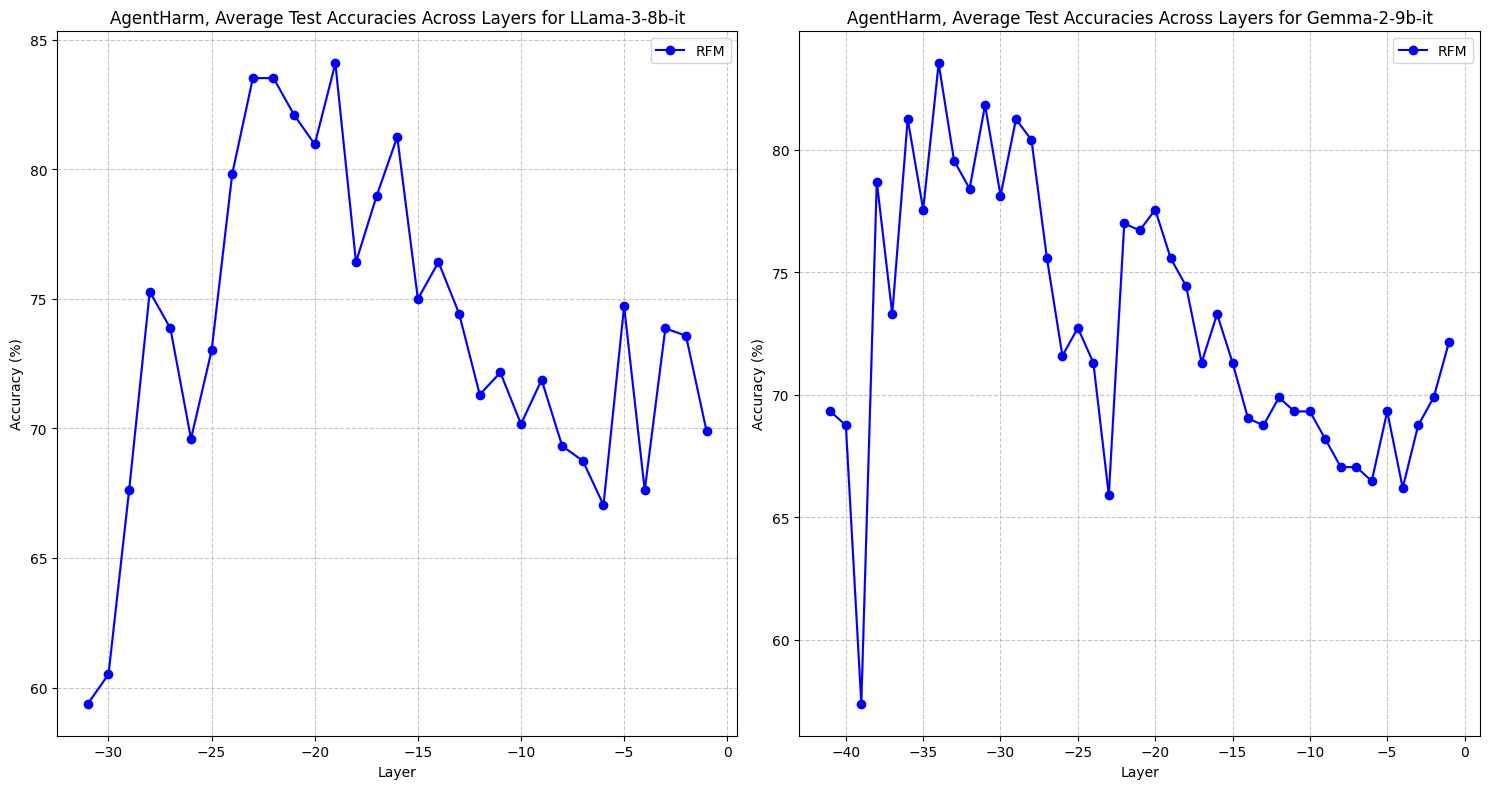

In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds
methods = ['rfm']#, 'logistic']
models = ['llama_3_8b', 'gemma_2_9b']

# Initialize dictionaries to store results
all_results = {}

for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Path for test metrics
        path_test = f'/u/dbeaglehole/mech_interp/neural_controllers/quantitative_comparisons/agentharm_results/{model}_it_{method}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path_test):
            print(f"File not found: {path_test}")
            continue
            
        # Load test results
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding non-dict entries)
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Collect per-layer metrics
        for key in layers_test:
            if key not in all_results[model]['test'][method]:
                all_results[model]['test'][method][key] = []
            all_results[model]['test'][method][key].append(test_results[key]['acc'])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        print("layer_data.keys()", layer_data.keys())
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            print("layers", layers)
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    plt.title(f'AgentHarm, Average Test Accuracies Across Layers for {model.replace(model[0], model[0].upper()).replace("_", "-")}-it')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig('agentharm_test_accuracies_across_layers.pdf', format='pdf')
plt.show()